In [183]:
import matplotlib.pyplot as plt
%matplotlib inline

In [204]:
import pandas as pd
import numpy as np
import json

import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from bs4 import BeautifulSoup

#create regex pattern
re_pattern = re.compile('[^a-zA-Z]')

# create stemmer
stemmer = SnowballStemmer('english')

#create stopwords
eng_stop = set(stopwords.words('english'))

def concatenate_text_data(course_dict):
    name = course_dict['name']
    faq = course_dict['faq']
    syllabus = BeautifulSoup(course_dict['courseSyllabus']).text
    short_desc = course_dict['shortDescription']
    about = BeautifulSoup(course_dict['aboutTheCourse']).text
    return " ".join([name, syllabus, short_desc, about])

def tokenize_text(text):
    """clean and tokenize a job description"""
    #should modify this to get rid of single letter words or ' caused junk
    clean_text = re_pattern.sub(" ", text).lower()
    tokenized_desc = [stemmer.stem(word) for word in clean_text.split() if word not in eng_stop]
    return tokenized_desc

def get_top_n_words(course_id, n=5):
    index_val = course_id_to_index[int(course_id)]
    top_n_index = np.argsort(tfidf_mat.getrow(index_val).todense())[-1:-(n + 1):-1, 0]
    words = [feature_mapping[i] for i in top_n_index.tolist()[0]]
    tfidf_vals = tfidf_mat[index_val, top_n_index].data
    return zip(words, tfidf_vals)

def get_n_most_similar_indices(input_text, tfidf_mat, vectorizer, n=5):
    input_tfidf = vectorizer.transform([input_text])
    cos_sims_sparse = tfidf_mat.dot(input_tfidf.T) #vects already have unit norm
    n = min(n, cos_sims_sparse.nnz) # only return elements with non-zero similarity
    cos_sims = cos_sims_sparse.todense() #shape: (m x 1)
    top_n_indices = np.argsort(cos_sims, axis=0)[-1:-(n + 1):-1, 0]
    return top_n_indices.ravel().tolist()[0]

def build_recommend_table(input_text, tfidf_mat, vectorizer, course_list, n=5):
    indices = get_n_most_similar_indices(input_text, tfidf_mat, vectorizer, n=n)
    header = ['Course Name', 'Course Description']
    table = [header]
    for i in indices:
        course = course_list[i]
        name = course['name']
        short_desc = course['shortDescription']
        url = 'https://www.coursera.org/course/' + course['shortName']
        table.append([name, short_desc, url])
    return table

# dump objs to pickles
if __name__ == '__main__':

    # coursera --------------------
    with open('../data/coursera/coursera_courses.json') as c_file:
        coursera_courses = json.load(c_file)
        course_list = coursera_courses['elements']

    course_id_to_index = {}
    course_text_list = []

    i = 0
    for course in coursera_courses['elements']:
        if course['language'] == 'en':
            course_id_to_index[course['id']] = i
            course_text_list.append(concatenate_text_data(course))
            i += 1

    # ny jobs --------------------
    ny_jobs_raw = open('../data/nyc/ny_jobs_data.json').read()
    ny_jobs_data = json.loads(ny_jobs_raw)

    ny_jobs_columns = [col['fieldName'] for col in ny_jobs_data['meta']['view']['columns']]

    ny_jobs_desc_index = ny_jobs_columns.index('job_description')
    ny_jobs_title_index = ny_jobs_columns.index('business_title') #there's also civic title

    # could loop through this once
    ny_jobs_descriptions = [job[ny_jobs_desc_index] for job in ny_jobs_data['data']]
    ny_jobs_titles = [job[ny_jobs_title_index] for job in ny_jobs_data['data']]

    # github jobs -----------------
    git_data = json.load(open('../data/github/github_postings'))
    git_jobs_descriptions = []
    git_jobs_titles = []

    for job in git_data:
        git_jobs_descriptions.append(BeautifulSoup(job['description']).text) #need to strip html
        git_jobs_titles.append(job['title'])

    # model building -----------------
    combined_text = course_text_list + ny_jobs_descriptions + git_jobs_descriptions
    vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
    tfidf_mat = vectorizer.fit_transform(combined_text)
    feature_mapping = vectorizer.get_feature_names()

    course_tfidf = tfidf_mat[:len(course_text_list), :]
    job_tfidf = tfidf_mat[len(course_text_list):, :]

SyntaxError: invalid syntax (<ipython-input-204-f9371818461a>, line 78)

In [ ]:
from sklearn.decomposition import TruncatedSVD
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

In [233]:
course_cats = [course['links'].get('categories', [-1]) for course in course_list]
for course in course_cats:
    if len(course) == 1:
        if course[0] == -1:
            print course

[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]


In [291]:
mlb = MultiLabelBinarizer()
course_cats_binarized = mlb.fit_transform(course_cats)
print course_cats_binarized.shape
print course_cats_binarized.sum(axis=1).mean()
course_cats_binarized.sum(axis=0) > 40

(916, 26)
2.23253275109


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True,  True], dtype=bool)

In [207]:
svd = TruncatedSVD(n_components=1000, random_state=10)
tfidf_mat_red = svd.fit_transform(tfidf_mat)
c_tfidf_red = tfidf_mat_red[:len(course_text_list), :]

In [281]:
# filter to only tags with > 40 courses
mask = course_cats_binarized.sum(axis=0) > 40
course_cats_binarized = course_cats_binarized[:, mask]
print mask.nonzero()[0].tolist()
print mlb.classes_.shape, mask.shape
print mlb.classes_[mask]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
(26,) (22,)
[-1  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [288]:
course_cats_binarized[:5, :][:, mask].shape

(5, 22)

In [274]:
label_arr_to_cat_id = {}
for i, k in enumerate(mask.nonzero()[0].tolist()):
    label_arr_to_cat_id[i] = mlb.classes_[k]
label_arr_to_cat_id

{0: -1,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22}

In [ ]:
label_arr_to_cat_id[0]

In [209]:
clf = MultinomialNB()
ovr = OneVsRestClassifier(clf, 1)
ovr.fit(course_tfidf, course_cats_binarized)
np.sum(ovr.predict(course_tfidf)) # returns 0 for all inputs

0

In [210]:
from sklearn.metrics import hamming_loss

def hamming_scorer(estimator, X, true):
    pred = estimator.predict(X)
    intersect = np.intersect1d(pred.ravel().nonzero()[0], true.ravel().nonzero()[0])
    union = np.union1d(pred.ravel().nonzero()[0], true.ravel().nonzero()[0])
    return float(len(intersect)) / len(union)

def hamming_loss_fn(estimator, X, y):
    pred = estimator.predict(X)
    return hamming_loss(y, pred)

def false_positives(estimator, X, y):
    pred = estimator.predict(X)
    num_labels = len(y.ravel().nonzero()[0])
    intercept = np.intersect1d(pred.ravel().nonzero()[0], y.ravel().nonzero()[0])
    num_wrong = num_labels - len(intercept)
    return float(num_wrong) / num_labels

In [211]:
clf = LinearSVC()
ovr = OneVsRestClassifier(clf, 1)
ovr.fit(course_tfidf, course_cats_binarized)
print np.sum(ovr.predict(course_tfidf)) # returns 0 for all inputs
print ovr.score(course_tfidf, course_cats_binarized)
print hamming_score(ovr.predict(course_tfidf), course_cats_binarized)

1909
0.9596069869
0.976422347514


In [212]:
clf = LinearSVC()
ovr = OneVsRestClassifier(clf, 1)
ovr.fit(c_tfidf_red, course_cats_binarized)
print np.sum(ovr.predict(c_tfidf_red)) # returns 0 for all inputs
print ovr.score(c_tfidf_red, course_cats_binarized)
print hamming_score(ovr.predict(c_tfidf_red), course_cats_binarized)

1619
0.736899563319
0.809233891426


#Cross Val Using Hamming Score and Loss

In [213]:
clf = LinearSVC(class_weight='auto')
ovr = OneVsRestClassifier(clf, 1)
print "Hamming Score"
print "TFIDF:", np.mean(cross_val_score(ovr, course_tfidf, y=course_cats_binarized, scoring=hamming_scorer, cv=10))
print "TFIDF-LSA:", np.mean(cross_val_score(ovr, c_tfidf_red, y=course_cats_binarized, scoring=hamming_scorer, cv=10))

Hamming Score
TFIDF: 0.449553634555
TFIDF-LSA: 0.433520103592


In [214]:
clf = LinearSVC(class_weight='auto')
ovr = OneVsRestClassifier(clf, 1)
print "Hamming Loss"
print "TFIDF:", np.mean(cross_val_score(ovr, course_tfidf, y=course_cats_binarized, scoring=hamming_loss_fn, cv=10))
print "TFIDF-LSA:", np.mean(cross_val_score(ovr, c_tfidf_red, y=course_cats_binarized, scoring=hamming_loss_fn, cv=10))

Hamming Loss
TFIDF: 0.0679157798723
TFIDF-LSA: 0.0833498023715


#Testing Class Weighting
## SVD 1000

###TFIDF Weighted has best score
###TFIDF-LSA Weighted has least FP

Hamming Score  
TFIDF: 0.304183998663  
TFIDF Weighted: 0.406202723935  *Best Score*

TFIDF-LSA: 0.33431343696  
TFIDF-LSA Weighted: 0.379689217922  

False Positives  
TFIDF: 0.679694476788  
TFIDF Weighted: 0.412562145694  

TFIDF-LSA: 0.641377265343  
TFIDF-LSA Weighted: 0.328548232699 *Best Loss*

# Testing Number of Dimensions
## SVD 400 vs TFIDF

Hamming Score  
TFIDF: 0.304183998663  
TFIDF-LSA: 0.278493742227  

False Positives
TFIDF: 0.679694476788  
TFIDF-LSA: 0.704217180111  

## SVD 600 vs TFIDF

Hamming Score  
TFIDF: 0.304183998663  
TFIDF-LSA: 0.313730139948  

False Positives
TFIDF: 0.679694476788  
TFIDF-LSA: 0.663058220398  

## SVD 1000 vs TFIDF -- Winner

Hamming Score  
TFIDF: 0.304183998663  
TFIDF-LSA: 0.334313436964  

False Positives
TFIDF: 0.679694476788  
TFIDF-LSA: 0.641377265343  

## SVD 2000 vs TFIDF

Hamming Score  
TFIDF: 0.304183998663  
TFIDF-LSA: 0.322470943783  

False Positives
TFIDF: 0.679694476788  
TFIDF-LSA: 0.657505814163  

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


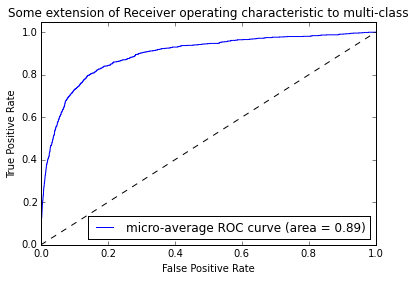

In [247]:
X = c_tfidf_red
y = course_cats_binarized
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=1)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=1, class_weight='auto'))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Plot of a ROC curve for a specific class
# plt.figure()
# plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [248]:
print np.argmax(fpr['micro'] > .05) #1021 for >.05
thresholds[1021]

1021


0.033933505260682728

# Testing Different Classifiers

In [217]:
# clf = svm.SVC(kernel='rbf', probability=True,
#                                  random_state=1, class_weight='auto')
# ovr = OneVsRestClassifier(clf, 1)
print "Hamming Score"
print "TFIDF:", np.mean(cross_val_score(ovr, course_tfidf, y=course_cats_binarized, scoring=hamming_scorer, cv=10))
print "TFIDF-LSA:", np.mean(cross_val_score(ovr, c_tfidf_red, y=course_cats_binarized, scoring=hamming_scorer, cv=10))

print "Hamming Loss"
print "TFIDF:", np.mean(cross_val_score(ovr, course_tfidf, y=course_cats_binarized, scoring=hamming_loss_fn, cv=10))
print "TFIDF-LSA:", np.mean(cross_val_score(ovr, c_tfidf_red, y=course_cats_binarized, scoring=hamming_loss_fn, cv=10))

Hamming Score
TFIDF: 0.449553634555
TFIDF-LSA: 0.433520103592
Hamming Loss
TFIDF:

TypeError: Expected sequence or array-like, got estimator OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)